# **Single-Cell RNA-Seq Analysis Project**

In this project, you will work with the `norman` dataset from the `perturbation_data_analysis` exercise:

In [336]:
import os
import sys
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [337]:
# Append the root of the Git repository to the path.
git_root = os.popen(cmd="git rev-parse --show-toplevel").read().strip()
sys.path.append(git_root)

from src.exercises.perturbation_data_analysis import pertdata as pt  # noqa: E402

norman = pt.PertData.from_repo(name="norman", save_dir="data")

print(norman)

Dataset directory already exists: data\norman
Loading dataset: norman
PertData object
    name: norman
    path: data\norman
    adata: AnnData object with n_obs x n_vars = 91205 x 5045


In [338]:
adata = norman.adata
adata

AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'

In [339]:
adata.obs.head()

,condition,cell_type,dose_val,control,condition_name,condition_fixed
cell_barcode,,,,,,
AAACCTGAGGCATGTG-1,TSC22D1+ctrl,A549,1+1,0,A549_TSC22D1+ctrl_1+1,TSC22D1
AAACCTGAGGCCCTTG-1,KLF1+MAP2K6,A549,1+1,0,A549_KLF1+MAP2K6_1+1,KLF1+MAP2K6
AAACCTGCACGAAGCA-1,ctrl,A549,1,1,A549_ctrl_1,ctrl
AAACCTGCAGACGTAG-1,CEBPE+RUNX1T1,A549,1+1,0,A549_CEBPE+RUNX1T1_1+1,CEBPE+RUNX1T1
AAACCTGCAGCCTTGG-1,MAML2+ctrl,A549,1+1,0,A549_MAML2+ctrl_1+1,MAML2


In [340]:
adata.var.head()

,gene_name
gene_id,
ENSG00000239945,RP11-34P13.8
ENSG00000223764,RP11-54O7.3
ENSG00000187634,SAMD11
ENSG00000187642,PERM1
ENSG00000188290,HES4


In [341]:
print(adata.obs.columns.tolist())

['condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed']


In [342]:
print(adata.obs["condition"].value_counts())


condition
ctrl             7353
CEBPE+RUNX1T1    1030
KLF1+ctrl         997
TBX3+TBX2         969
SLC4A1+ctrl       853
                 ... 
PLK4+STIL          66
SAMD1+TGFBR2       59
JUN+CEBPB          52
CBL+UBASH3A        50
C3orf72+FOXL2      49
Name: count, Length: 284, dtype: int64


In [343]:
adata.obs["control"].value_counts()

control
0    83852
1     7353
Name: count, dtype: int64

In [344]:
# PCA
sc.tl.pca(adata, svd_solver="randomized", zero_center=False)

In [345]:
adata.uns["pca"]["variance_ratio"][:5]


array([0.0073588 , 0.05133133, 0.03504888, 0.01979576, 0.01780374],
      dtype=float32)

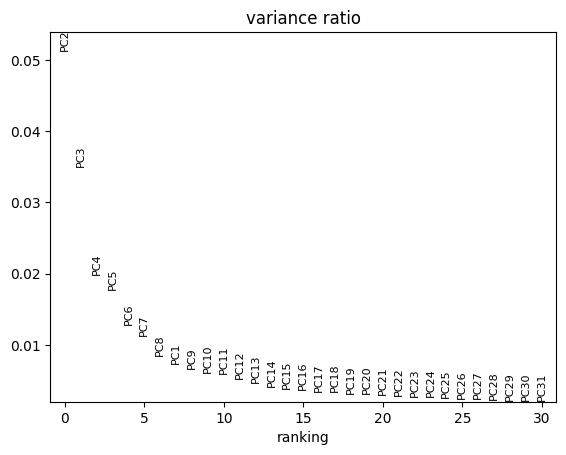

In [346]:
#variance ratio plot - showing PCA with highest variance
sc.pl.pca_variance_ratio(adata, log=False)

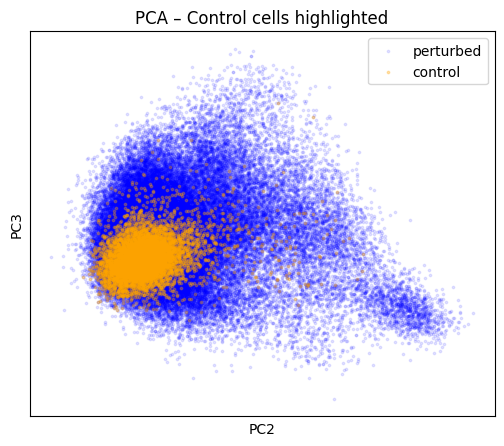

In [347]:
#PCA plot
X = adata.obsm["X_pca"][:, [1, 2]] # PC2, PC3
control_mask = adata.obs["control"] == 1

plt.figure(figsize=(6, 5))

# background all cells
plt.scatter(
    X[:, 0], X[:, 1],
    s=3,
    c="blue",
    alpha=0.1,
    label="perturbed"
)

# foreground control
plt.scatter(
    X[control_mask, 0], X[control_mask, 1],
    s=3,
    c="orange",
    alpha=0.3,
    label="control"
)

plt.xlabel("PC2")
plt.ylabel("PC3")
plt.title("PCA – Control cells highlighted")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()


Subcluster size: 1447


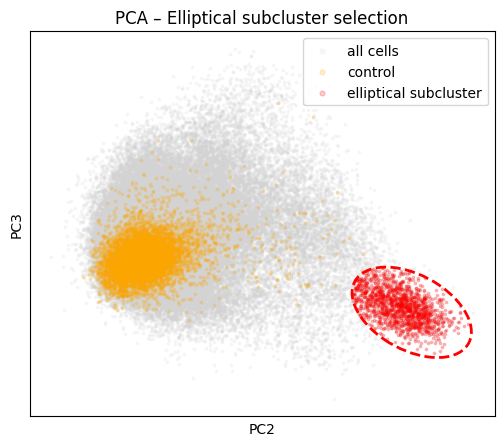

In [348]:
#PCA subcluster

#PCA coordinates (PC2, PC3)
X = adata.obsm["X_pca"][:, [1, 2]]
pc2 = X[:, 0]
pc3 = X[:, 1]

#control mask
control_mask = adata.obs["control"] == 1

#ellipse parameters
center_x, center_y = 14, -5
width = 8
height = 5
angle_deg = -40

#elliptical mask
theta = np.deg2rad(angle_deg)
cos_t, sin_t = np.cos(theta), np.sin(theta)

# shift to ellipse center
x = pc2 - center_x
y = pc3 - center_y

# rotate points (inverse rotation)
x_rot = cos_t * x + sin_t * y
y_rot = -sin_t * x + cos_t * y

# ellipse equation
subcluster_mask = (
    (x_rot / (width / 2))**2 +
    (y_rot / (height / 2))**2
) <= 1

print("Subcluster size:", subcluster_mask.sum())

#plotting
plt.figure(figsize=(6, 5))

# all cells
plt.scatter(
    pc2, pc3,
    s=3,
    c="lightgray",
    alpha=0.15,
    label="all cells"
)

# control cells
plt.scatter(
    pc2[control_mask],
    pc3[control_mask],
    s=3,
    c="orange",
    alpha=0.2,
    label="control"
)

# elliptical subcluster
plt.scatter(
    pc2[subcluster_mask],
    pc3[subcluster_mask],
    s=3,
    c="red",
    alpha=0.2,
    label="elliptical subcluster"
)

# ellipse overlay
ellipse = Ellipse(
    (center_x, center_y),
    width=width,
    height=height,
    angle=angle_deg,
    edgecolor="red",
    facecolor="none",
    linewidth=2,
    linestyle="--"
)
plt.gca().add_patch(ellipse)

plt.xlabel("PC2")
plt.ylabel("PC3")
plt.title("PCA – Elliptical subcluster selection")
plt.legend(markerscale=2)
plt.xticks([])
plt.yticks([])
plt.show()

# store result
adata.obs["pca_subcluster"] = "rest"
adata.obs.loc[subcluster_mask, "pca_subcluster"] = "subcluster"
adata.obs["pca_subcluster"] = adata.obs["pca_subcluster"].astype("category")


In [349]:
adata.obs["pca_subcluster"].value_counts()

pca_subcluster
rest          89758
subcluster     1447
Name: count, dtype: int64

In [350]:
#check new column
adata.obs.head()

,condition,cell_type,dose_val,control,condition_name,condition_fixed,pca_subcluster
cell_barcode,,,,,,,
AAACCTGAGGCATGTG-1,TSC22D1+ctrl,A549,1+1,0,A549_TSC22D1+ctrl_1+1,TSC22D1,rest
AAACCTGAGGCCCTTG-1,KLF1+MAP2K6,A549,1+1,0,A549_KLF1+MAP2K6_1+1,KLF1+MAP2K6,rest
AAACCTGCACGAAGCA-1,ctrl,A549,1,1,A549_ctrl_1,ctrl,rest
AAACCTGCAGACGTAG-1,CEBPE+RUNX1T1,A549,1+1,0,A549_CEBPE+RUNX1T1_1+1,CEBPE+RUNX1T1,rest
AAACCTGCAGCCTTGG-1,MAML2+ctrl,A549,1+1,0,A549_MAML2+ctrl_1+1,MAML2,rest


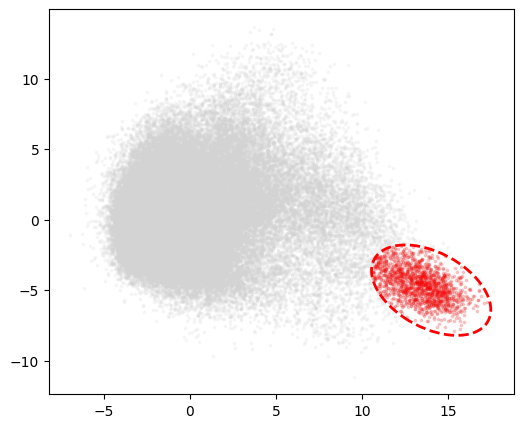

In [351]:
#PCA subcluster alternative optic

center = (14, -5)
width = 8
height = 5
angle = -40

ellipse = Ellipse(
    center,
    width=width,
    height=height,
    angle=angle,
    edgecolor="red",
    facecolor="none",
    linewidth=2,
    linestyle="--"
)

plt.figure(figsize=(6, 5))
plt.scatter(pc2, pc3, s=3, c="lightgray", alpha=0.15)
plt.scatter(pc2[subcluster_mask], pc3[subcluster_mask], s=3, c="red", alpha=0.15)
plt.gca().add_patch(ellipse)
plt.show()


In [352]:
#caculate impact of genes on PC2
pc2_loadings = adata.varm["PCs"][:, 1]  # PC2
genes = adata.var_names

pc2_df = pd.DataFrame({
    "gene": genes,
    "loading": pc2_loadings
})


In [353]:
pc2_df.sort_values("loading", ascending=False).head(20)

,gene,loading
2740,ENSG00000251562,0.145165
94,ENSG00000142669,0.124935
2738,ENSG00000245532,0.121848
1753,ENSG00000227706,0.108616
1663,ENSG00000204482,0.098273
2892,ENSG00000026025,0.095947
1664,ENSG00000204472,0.094838
4670,ENSG00000011600,0.093531
1960,ENSG00000130429,0.087372
3772,ENSG00000198736,0.084317


In [354]:
pc2_df.sort_values("loading", ascending=True).head(20)

,gene,loading
4825,ENSG00000108106,-0.134808
4842,ENSG00000099901,-0.122453
852,ENSG00000187514,-0.119509
331,ENSG00000173207,-0.116425
4209,ENSG00000239672,-0.115619
50,ENSG00000116649,-0.112655
1316,ENSG00000164104,-0.106890
3758,ENSG00000130656,-0.103250
2526,ENSG00000119403,-0.099770
2934,ENSG00000165732,-0.098327


In [355]:
adata.obs["pca_subcluster"].value_counts()


pca_subcluster
rest          89758
subcluster     1447
Name: count, dtype: int64

In [356]:
import scanpy as sc

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


In [357]:
import numpy as np
import scanpy as sc

# masks
sub_mask  = adata.obs["pca_subcluster"] == "subcluster"
ctrl_mask = adata.obs["control"] == 1   # your control indicator column

# keep only subcluster + control cells
adata_de = adata[sub_mask | ctrl_mask].copy()

# define a new 2-class label for DE
adata_de.obs["de_group"] = np.where(sub_mask[sub_mask | ctrl_mask], "subcluster", "ctrl")

# DE: subcluster vs ctrl
sc.tl.rank_genes_groups(
    adata_de,
    groupby="de_group",
    groups=["subcluster"],
    reference="ctrl",
    method="wilcoxon"
)

de_df = sc.get.rank_genes_groups_df(adata_de, group="subcluster")
de_df.head()


,names,scores,logfoldchanges,pvals,pvals_adj
0,ENSG00000204482,59.103004,6.514579,0.0,0.0
1,ENSG00000011600,58.329826,6.621373,0.0,0.0
2,ENSG00000197766,57.188118,2.385768,0.0,0.0
3,ENSG00000119535,57.133759,6.627395,0.0,0.0
4,ENSG00000026025,54.763554,1.958234,0.0,0.0


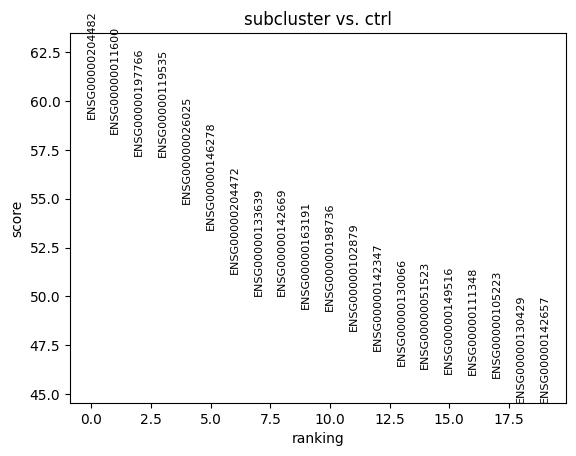

In [358]:
sc.pl.rank_genes_groups(
    adata_de,
    n_genes=20,
    sharey=False
)


In [359]:
de_df = sc.get.rank_genes_groups_df(
    adata_de,
    group="subcluster"
)

de_df.head(200)


,names,scores,logfoldchanges,pvals,pvals_adj
0,ENSG00000204482,59.103004,6.514579,0.000000e+00,0.000000e+00
1,ENSG00000011600,58.329826,6.621373,0.000000e+00,0.000000e+00
2,ENSG00000197766,57.188118,2.385768,0.000000e+00,0.000000e+00
3,ENSG00000119535,57.133759,6.627395,0.000000e+00,0.000000e+00
4,ENSG00000026025,54.763554,1.958234,0.000000e+00,0.000000e+00
...,...,...,...,...,...
195,ENSG00000135506,11.335399,1.042793,8.763186e-30,9.716543e-29
196,ENSG00000204272,11.091972,0.349434,1.372275e-28,1.505028e-27
197,ENSG00000182287,11.068896,0.978141,1.775740e-28,1.939092e-27
198,ENSG00000137193,11.063169,0.593753,1.892907e-28,2.062573e-27


In [360]:
gene = "ENSG00000163563"  # eines deiner Gene

import numpy as np

expr_sub = adata_de[
    adata_de.obs["de_group"] == "subcluster",
    gene
].X

# sparse-safe Mittelwert
mean_expr = expr_sub.mean()
frac_nonzero = (expr_sub > 0).mean()

mean_expr, frac_nonzero


(np.float32(0.5654465), np.float64(0.17415342087076713))

In [361]:
top_genes = (
    de_df.query("scores > 10")
         .sort_values("logfoldchanges", ascending=False)
         .head(20)["names"]
         .tolist()
)

top_genes[:5], len(top_genes)

print(top_genes)


['ENSG00000156575', 'ENSG00000263961', 'ENSG00000163563', 'ENSG00000115956', 'ENSG00000158517', 'ENSG00000122862', 'ENSG00000082074', 'ENSG00000139278', 'ENSG00000186652', 'ENSG00000257017', 'ENSG00000116701', 'ENSG00000066294', 'ENSG00000150681', 'ENSG00000081237', 'ENSG00000092067', 'ENSG00000135046', 'ENSG00000105205', 'ENSG00000169403', 'ENSG00000119535', 'ENSG00000011600']


In [362]:
top_gene_symbols = (
    adata_de.var
    .loc[top_genes, "gene_name"]
    .tolist()
)
print(top_gene_symbols)

['PRG3', 'C1orf186', 'MNDA', 'PLEK', 'NCF1', 'SRGN', 'FYB', 'GLIPR1', 'PRG2', 'HP', 'NCF2', 'CD84', 'RGS18', 'PTPRC', 'CEBPE', 'ANXA1', 'CLC', 'PTAFR', 'CSF3R', 'TYROBP']


In [363]:
adata_de.obs.head()

,condition,cell_type,dose_val,control,condition_name,condition_fixed,pca_subcluster,de_group
cell_barcode,,,,,,,,
AAACCTGCACGAAGCA-1,ctrl,A549,1,1,A549_ctrl_1,ctrl,rest,ctrl
AAACCTGCATCTCCCA-1,ctrl+CEBPE,A549,1+1,0,A549_ctrl+CEBPE_1+1,CEBPE,subcluster,subcluster
AAACCTGGTATAATGG-1,ctrl,A549,1,1,A549_ctrl_1,ctrl,rest,ctrl
AAACCTGTCCGATATG-1,ctrl,A549,1,1,A549_ctrl_1,ctrl,rest,ctrl
AAACGGGCAATGGACG-1,ctrl,A549,1,1,A549_ctrl_1,ctrl,rest,ctrl


In [364]:
adata_de.obs["pca_subcluster"].value_counts()

pca_subcluster
rest          7353
subcluster    1447
Name: count, dtype: int64

In [365]:
import numpy as np

np.random.seed(0)

sub_mask = (adata_de.obs["de_group"] == "subcluster").values
ctrl_mask = (adata_de.obs["de_group"] == "ctrl").values

sub_idx = np.where(sub_mask)[0]
ctrl_idx = np.where(ctrl_mask)[0]

# z.B. alle Subcluster-Zellen + 2000 Rest-Zellen
ctrl_sample = np.random.choice(ctrl_idx, size=len(sub_idx), replace=False)

keep_idx = np.concatenate([sub_idx, ctrl_sample])
adata_hm = adata_de[keep_idx].copy()

adata_hm.obs["de_group"].value_counts()


de_group
ctrl          1447
subcluster    1447
Name: count, dtype: int64

In [366]:
top_gene_symbols = (
    adata_hm.var
    .loc[top_genes, "gene_name"]
    .tolist()
)
print(top_gene_symbols)

['PRG3', 'C1orf186', 'MNDA', 'PLEK', 'NCF1', 'SRGN', 'FYB', 'GLIPR1', 'PRG2', 'HP', 'NCF2', 'CD84', 'RGS18', 'PTPRC', 'CEBPE', 'ANXA1', 'CLC', 'PTAFR', 'CSF3R', 'TYROBP']


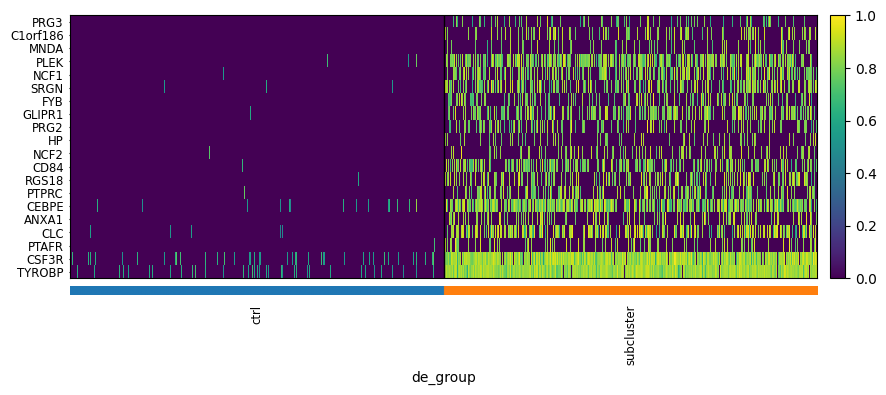

In [367]:
import scanpy as sc

top_genes = adata_hm.var.loc[top_genes, "gene_name"].tolist()

sc.pl.heatmap(
    adata_hm,
    var_names=top_genes,
    groupby="de_group",
    swap_axes=True,
    show_gene_labels=True,
    gene_symbols="gene_name",
    standard_scale="var"
)

In [368]:
import scanpy as sc

# ------------------------------------------------------------
# 1) Nachbarschaftsgraph berechnen
#    (auf PCA-Basis, Standard für UMAP)
# ------------------------------------------------------------
sc.pp.neighbors(
    adata,
    n_neighbors=15,
    n_pcs=30
)

# ------------------------------------------------------------
# 2) UMAP berechnen
# ------------------------------------------------------------
sc.tl.umap(adata)

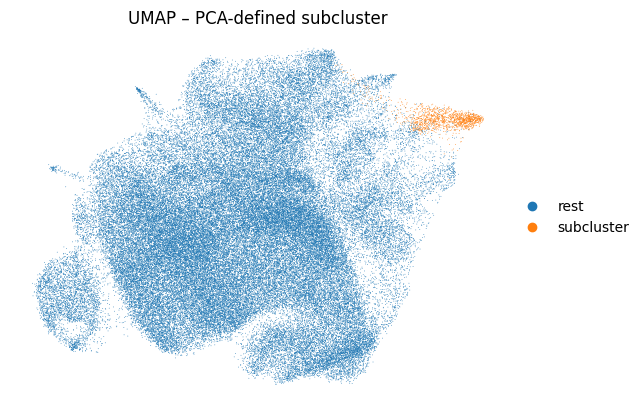

In [369]:
# ------------------------------------------------------------
# 3) UMAP plotten – Subcluster vs Rest
# ------------------------------------------------------------
sc.pl.umap(
    adata,
    color="pca_subcluster",
    frameon=False,
    title="UMAP – PCA-defined subcluster"
)

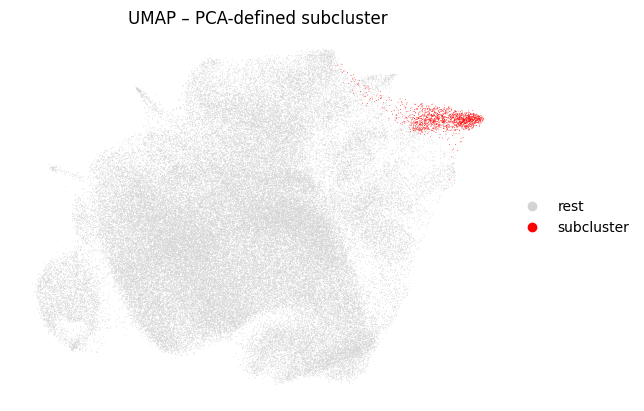

In [370]:
sc.pl.umap(
    adata,
    color="pca_subcluster",
    palette=["lightgrey","red"],
    frameon=False,
    title="UMAP – PCA-defined subcluster"
)

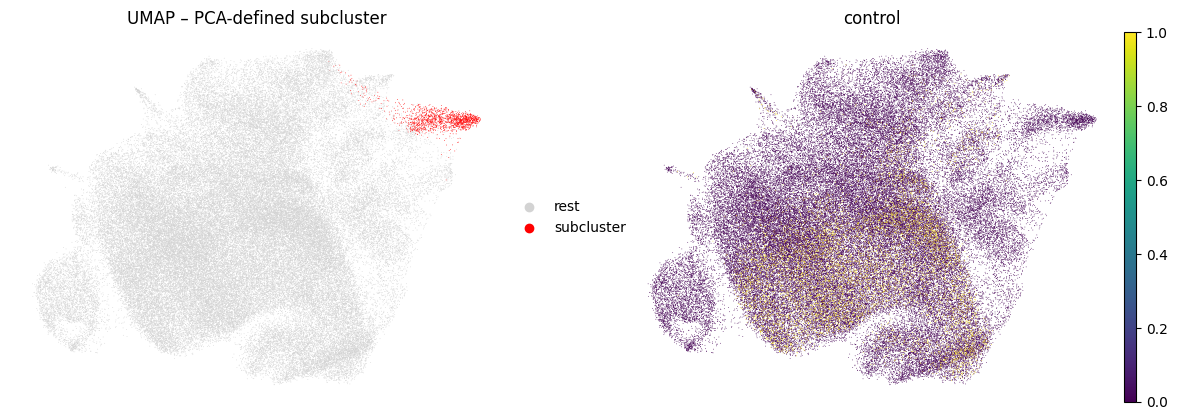

In [371]:

sc.pl.umap(
    adata,
    color=["pca_subcluster", "control"],
    frameon=False,
    title="UMAP – PCA-defined subcluster"
)

In [372]:
import scanpy as sc

# ------------------------------------------------------------
# 1) Nachbarschaftsgraph berechnen
#    (auf PCA-Basis, Standard für UMAP)
# ------------------------------------------------------------
sc.pp.neighbors(
    adata_de,
    n_neighbors=15,
    n_pcs=30
)

# ------------------------------------------------------------
# 2) UMAP berechnen
# ------------------------------------------------------------
sc.tl.umap(adata_de)

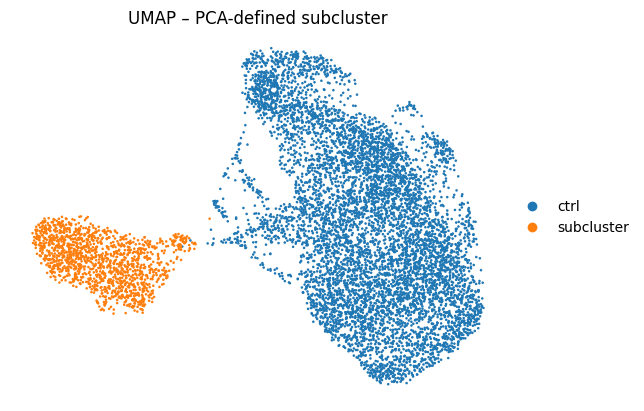

In [373]:
sc.pl.umap(
    adata_de,
    color="de_group",
    frameon=False,
    title="UMAP – PCA-defined subcluster"
)

In [374]:
#wich conditions lead to the subcluster?
cond_col = "condition"

sub = adata.obs[adata.obs["pca_subcluster"] == "subcluster"]

counts = sub[cond_col].value_counts(dropna=False)
perc = sub[cond_col].value_counts(normalize=True, dropna=False) * 100

summary = (counts.to_frame("count")
           .join(perc.to_frame("percent"))
           .sort_values("count", ascending=False))

print(summary.to_string())


                 count    percent
condition                        
CEBPA+ctrl         201  13.890809
ctrl+CEBPA         141   9.744299
CEBPE+CEBPA        130   8.984105
KLF1+CEBPA         105   7.256393
ctrl+CEBPE         102   7.049067
CEBPE+SPI1          68   4.699378
CEBPE+ctrl          68   4.699378
CEBPE+RUNX1T1       59   4.077402
ZC3HAV1+CEBPA       57   3.939185
FOSB+CEBPE          50   3.455425
JUN+CEBPA           42   2.902557
CEBPB+OSR2          41   2.833449
CEBPE+CEBPB         40   2.764340
FOSB+CEBPB          39   2.695232
CEBPB+CEBPA         38   2.626123
FOSB+OSR2           30   2.073255
CEBPB+ctrl          29   2.004147
ctrl+CEBPB          24   1.658604
ETS2+CEBPE          22   1.520387
CEBPB+MAPK1         15   1.036628
FOSB+ctrl           11   0.760194
CEBPE+KLF1          11   0.760194
ctrl+OSR2           10   0.691085
ZC3HAV1+CEBPE       10   0.691085
OSR2+ctrl            9   0.621977
JUN+CEBPB            8   0.552868
ETS2+MAPK1           7   0.483760
SET+CEBPE     

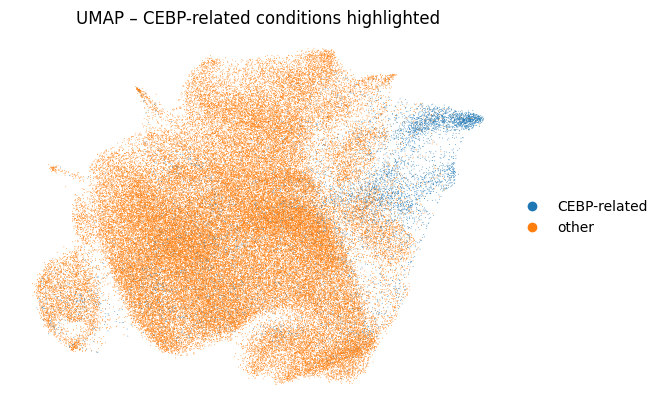

In [375]:
conditions_of_interest = [
    "CEBPA+ctrl", "ctrl+CEBPA",
    "CEBPE+ctrl", "ctrl+CEBPE",
    "CEBPB+ctrl", "ctrl+CEBPB",
    "CEBPE+CEBPA", "CEBPB+CEBPA"
]

conditions_of_interest = [
"CEBPA+ctrl", "ctrl+CEBPA",
"CEBPE+CEBPA",
"KLF1+CEBPA",
"ctrl+CEBPE", "CEBPE+ctrl",
]

conditions_of_interest = [
"CEBPA+ctrl", "ctrl+CEBPA",
"CEBPE+ctrl", "ctrl+CEBPE",
"CEBPB+ctrl", "ctrl+CEBPB",
"CEBPE+CEBPA", "CEBPB+CEBPA",
"KLF1+CEBPA",
"ZC3HAV1+CEBPA",
"JUN+CEBPA",
"CEBPE+SPI1",
"CEBPE+RUNX1T1",
"FOSB+CEBPE",
"CEBPE+CEBPB",
"ETS2+CEBPE",
"CEBPE+KLF1",
"ZC3HAV1+CEBPE",
"SET+CEBPE",
"CEBPE+CNN1",
"CEBPE+PTPN12",
"CEBPB+OSR2",
"FOSB+CEBPB",
"CEBPB+MAPK1",
"JUN+CEBPB",
"LYL1+CEBPB",
"CEBPB+PTPN12"
]

adata.obs["cond_focus"] = "other"
adata.obs.loc[
    adata.obs["condition"].isin(conditions_of_interest),
    "cond_focus"
] = "CEBP-related"

sc.pl.umap(
    adata,
    color="cond_focus",
    frameon=False,
    title="UMAP – CEBP-related conditions highlighted"
)


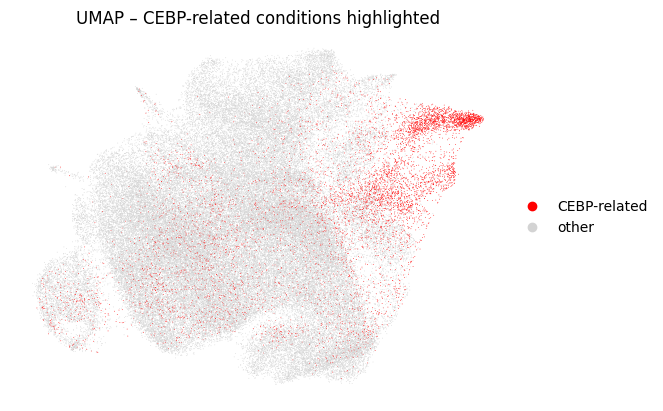

In [376]:
import scanpy as sc

sc.pl.umap(
    adata,
    color="cond_focus",
    palette=["red","lightgrey"],
    frameon=False,
    title="UMAP – CEBP-related conditions highlighted"
)



Choose one of the following tasks:

~~**Exploratory Data Analysis and Visualization**

- Objective: Explore the dataset to identify patterns and clusters.
- Tasks:
  - Perform dimensionality reduction using PCA, t-SNE, or UMAP.
  - Visualize gene expression profiles across different conditions or perturbations.
  - Create heatmaps of the top differentially expressed genes.
- Learning Outcomes:
  - Learn to visualize high-dimensional data.
  - Interpret clusters and patterns in the context of biological conditions.~~

**Machine Learning Classification**

- Objective: Build models to classify samples based on gene expression profiles.
- Tasks:
  - Split the dataset into training and testing sets.
  - Implement classification algorithms.
  - Evaluate model performance using metrics like accuracy, precision, recall, and ROC curves.
- Learning Outcomes:
  - Understand supervised learning techniques.
  - Learn model evaluation and validation strategies.

**Advanced Deep Learning Applications**

- Objective: Apply deep learning techniques to model complex patterns in the data.
- Tasks:
  - Implement autoencoders or variational autoencoders for dimensionality reduction.
  - Explore the use of GANs to generate synthetic gene expression data.
  - Analyze how deep learning models capture nonlinear relationships.
- Learning Outcomes:
  - Gain experience with deep learning frameworks.
  - Understand the applications of deep learning in genomics.